# Test Harness Development Notebook

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
from sklearn.preprocessing import LabelEncoder

%load_ext autoreload
%autoreload 2

### Load & Prepare Data

In [2]:
data = pd.read_csv("../data/electricity-normalized.csv")

In [3]:
# specify columns to keep and if categorical
cols = (
    ("day", True),
    ("period", True),
    ("nswdemand", False),
    ("vicdemand", False),
    ("transfer", False),
    ("class", True),
)

data_clean = data[[col for col, _ in cols]].copy(deep=True)

# label encode categorical
catcols = (col for col, iscat in cols if iscat)

for col in catcols:
    data_clean[col] = LabelEncoder().fit_transform(data_clean[col])

# convert to categorical
def categorize(df, cols):
    catcols = (col for col, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df


data_clean = categorize(data_clean, cols)


In [4]:
data_clean

,day,period,nswdemand,vicdemand,transfer,class
0,1,0,0.439155,0.422915,0.414912,1
1,1,1,0.415055,0.422915,0.414912,1
2,1,2,0.385004,0.422915,0.414912,1
3,1,3,0.314639,0.422915,0.414912,1
4,1,4,0.251116,0.422915,0.414912,0
...,...,...,...,...,...,...
45307,6,43,0.340672,0.255049,0.405263,0
45308,6,44,0.355549,0.241326,0.420614,0
45309,6,45,0.340970,0.247799,0.362281,0
45310,6,46,0.329366,0.345417,0.206579,1


### Experiment Development

In [5]:
from sklearn.ensemble import RandomForestClassifier

from test_harness.datasets.dataset import Dataset
from test_harness.experiments.experiment import Experiment

In [6]:
column_mapping = {
    "target": "class",
    "numerical_features": ["nswdemand", "vicdemand", "transfer"],
    "categorical_features": ["day", "period"],
}

ED_dataset = Dataset(
    full_df=data_clean, column_mapping=column_mapping, window_size=2500
)

In [8]:
# baseline 
baseline_experiment = Experiment(
    model=RandomForestClassifier(n_estimators=5, random_state=42), dataset=ED_dataset
)
baseline_experiment.run_baseline()

# topline
topline_experiment = Experiment(
    model=RandomForestClassifier(n_estimators=5, random_state=42), dataset=ED_dataset
)
topline_experiment.run_topline()

DETECTION WINDOW IDX: 1
WINDOW_START: 2500
DETECTION WINDOW IDX: 2
WINDOW_START: 5000
DETECTION WINDOW IDX: 3
WINDOW_START: 7500
DETECTION WINDOW IDX: 4
WINDOW_START: 10000
DETECTION WINDOW IDX: 5
WINDOW_START: 12500
DETECTION WINDOW IDX: 6
WINDOW_START: 15000
DETECTION WINDOW IDX: 7
WINDOW_START: 17500
DETECTION WINDOW IDX: 8
WINDOW_START: 20000
DETECTION WINDOW IDX: 9
WINDOW_START: 22500
DETECTION WINDOW IDX: 10
WINDOW_START: 25000
DETECTION WINDOW IDX: 11
WINDOW_START: 27500
DETECTION WINDOW IDX: 12
WINDOW_START: 30000
DETECTION WINDOW IDX: 13
WINDOW_START: 32500
DETECTION WINDOW IDX: 14
WINDOW_START: 35000
DETECTION WINDOW IDX: 15
WINDOW_START: 37500
DETECTION WINDOW IDX: 16
WINDOW_START: 40000
DETECTION WINDOW IDX: 17
WINDOW_START: 42500
DETECTION WINDOW IDX: 1
WINDOW_START: 2500
DETECTION WINDOW IDX: 2
WINDOW_START: 5000
DETECTION WINDOW IDX: 3
WINDOW_START: 7500
DETECTION WINDOW IDX: 4
WINDOW_START: 10000
DETECTION WINDOW IDX: 5
WINDOW_START: 12500
DETECTION WINDOW IDX: 6
WINDOW

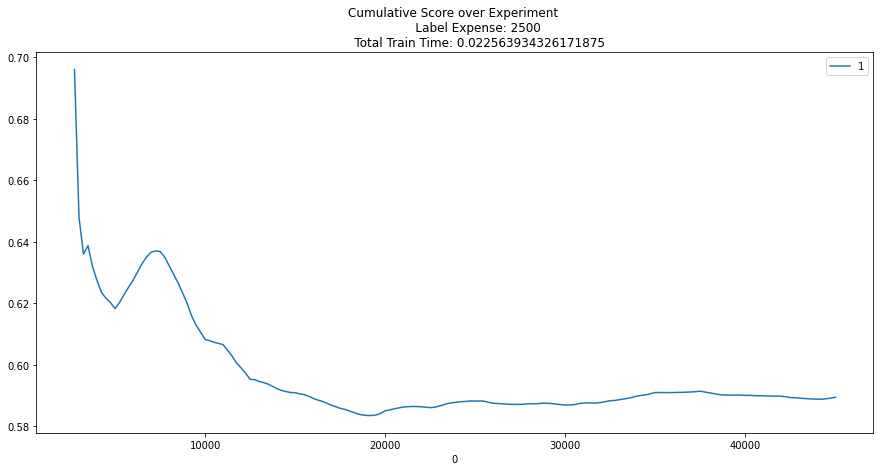

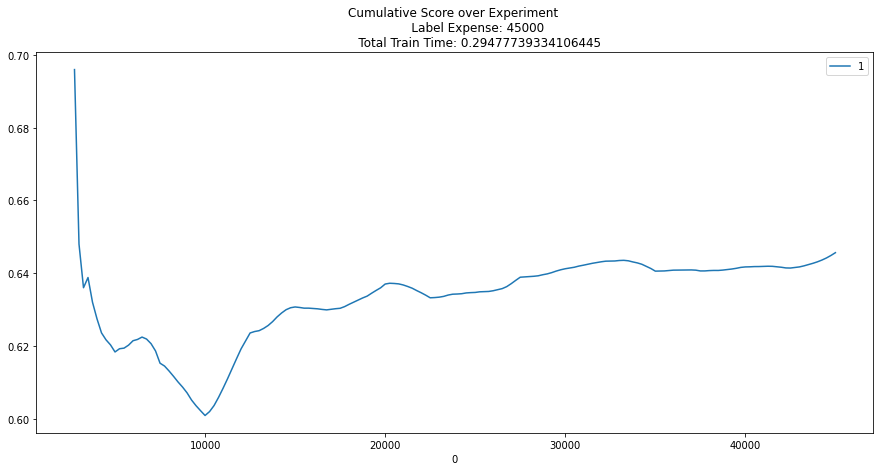

In [9]:
baseline_experiment.plot_error()
topline_experiment.plot_error()